# Classifying Shooting Incident Fatality: A Comprehensive Analysis

A complete end-to-end pipeline for case classification of shooting incident fatalities using NYPD Shooting Incident Data is laid out in this Jupyter Notebook. The problem goal is to determine whether a particular shooting incident is resulting in a murder (STATISTICAL_MURDER_FLAG) by using a variety of machine learning models. The procedure starts with preparing the data, then implements exploratory data analysis (EDA), preprocessing, model training, evaluation, hyperparameter tuning, and finally actionable recommendations for stakeholders.

## Step 1: Data Preparation

**Objective**

Load the dataset, clean it by treating missing values and encoding high-cardinality categoricals, and create features to improve the model performance.

**Business Importance**

In order to train the model to learn meaningful patterns, it must be subjected to accurate data preparation, which helps in noise reduction due to some missing or inconsistent data. In shooting incident analysis, engineered gun features related to temporal or geographic clusters disclose trends (time of day, or area) that could influence fatality rate and help law enforcement in resource allocation.

### 1.1 Import The Libraries 

In [76]:
# Import libraries for data manipulation, visualization, and modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report, confusion_matrix
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

### 1.2 Load and Inspect Data

In [77]:
# Load the dataset
data = pd.read_csv('NYPD_Shooting_Incident_Data__Historic_.csv')
data.head()

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,LOC_OF_OCCUR_DESC,PRECINCT,JURISDICTION_CODE,LOC_CLASSFCTN_DESC,LOCATION_DESC,STATISTICAL_MURDER_FLAG,...,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,228798151,05/27/2021,21:30:00,QUEENS,NaN,105,0.0,NaN,NaN,False,...,NaN,NaN,18-24,M,BLACK,1.058925e+06,180924.000000,40.662965,-73.730839,POINT (-73.73083868899994 40.662964620000025)
1,137471050,06/27/2014,17:40:00,BRONX,NaN,40,0.0,NaN,NaN,False,...,NaN,NaN,18-24,M,BLACK,1.005028e+06,234516.000000,40.810352,-73.924942,POINT (-73.92494232599995 40.81035186300006)
2,147998800,11/21/2015,03:56:00,QUEENS,NaN,108,0.0,NaN,NaN,True,...,NaN,NaN,25-44,M,WHITE,1.007668e+06,209836.531250,40.742607,-73.915492,POINT (-73.91549174199997 40.74260663300004)
3,146837977,10/09/2015,18:30:00,BRONX,NaN,44,0.0,NaN,NaN,False,...,NaN,NaN,<18,M,WHITE HISPANIC,1.006537e+06,244511.140625,40.837782,-73.919457,POINT (-73.91945661499994 40.83778200300003)
4,58921844,02/19/2009,22:58:00,BRONX,NaN,47,0.0,NaN,NaN,True,...,M,BLACK,45-64,M,BLACK,1.024922e+06,262189.406250,40.886238,-73.852910,POINT (-73.85290950899997 40.88623791800006)


In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27312 entries, 0 to 27311
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   INCIDENT_KEY             27312 non-null  int64  
 1   OCCUR_DATE               27312 non-null  object 
 2   OCCUR_TIME               27312 non-null  object 
 3   BORO                     27312 non-null  object 
 4   LOC_OF_OCCUR_DESC        1716 non-null   object 
 5   PRECINCT                 27312 non-null  int64  
 6   JURISDICTION_CODE        27310 non-null  float64
 7   LOC_CLASSFCTN_DESC       1716 non-null   object 
 8   LOCATION_DESC            12335 non-null  object 
 9   STATISTICAL_MURDER_FLAG  27312 non-null  bool   
 10  PERP_AGE_GROUP           17968 non-null  object 
 11  PERP_SEX                 18002 non-null  object 
 12  PERP_RACE                18002 non-null  object 
 13  VIC_AGE_GROUP            27312 non-null  object 
 14  VIC_SEX               

In [79]:
data.shape

(27312, 21)

In [80]:
data.describe()

,INCIDENT_KEY,PRECINCT,JURISDICTION_CODE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
count,2.731200e+04,27312.000000,27310.000000,2.731200e+04,27312.000000,27302.000000,27302.000000
mean,1.208605e+08,65.635362,0.326913,1.009449e+06,208127.401608,40.737892,-73.909051
std,7.341286e+07,27.305705,0.737743,1.837783e+04,31886.377757,0.087525,0.066272
min,9.953245e+06,1.000000,0.000000,9.149281e+05,125756.718750,40.511586,-74.249303
25%,6.386088e+07,44.000000,0.000000,1.000029e+06,182834.335938,40.668481,-73.943027
50%,9.037222e+07,68.000000,0.000000,1.007731e+06,194486.570312,40.700318,-73.915221
75%,1.888102e+08,81.000000,0.000000,1.016838e+06,239518.468750,40.824067,-73.882330
max,2.611902e+08,123.000000,2.000000,1.066815e+06,271127.687500,40.910818,-73.702046


In [81]:
data.isnull().sum()

INCIDENT_KEY                   0
OCCUR_DATE                     0
OCCUR_TIME                     0
BORO                           0
LOC_OF_OCCUR_DESC          25596
PRECINCT                       0
JURISDICTION_CODE              2
LOC_CLASSFCTN_DESC         25596
LOCATION_DESC              14977
STATISTICAL_MURDER_FLAG        0
PERP_AGE_GROUP              9344
PERP_SEX                    9310
PERP_RACE                   9310
VIC_AGE_GROUP                  0
VIC_SEX                        0
VIC_RACE                       0
X_COORD_CD                     0
Y_COORD_CD                     0
Latitude                      10
Longitude                     10
Lon_Lat                       10
dtype: int64

In [82]:
data.columns

Index(['INCIDENT_KEY', 'OCCUR_DATE', 'OCCUR_TIME', 'BORO', 'LOC_OF_OCCUR_DESC',
       'PRECINCT', 'JURISDICTION_CODE', 'LOC_CLASSFCTN_DESC', 'LOCATION_DESC',
       'STATISTICAL_MURDER_FLAG', 'PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE',
       'VIC_AGE_GROUP', 'VIC_SEX', 'VIC_RACE', 'X_COORD_CD', 'Y_COORD_CD',
       'Latitude', 'Longitude', 'Lon_Lat'],
      dtype='object')

### 1.3 Data Cleaning

- We handle missing values and do appropriate data preprocessing so we provide clean input to our modeling:

- Missing Values: Impute categorical features with unknown, drop any rows with missing target, and impute mean for the numerical features. 

- High Cardinality Categoricals: Use TargetEncoder on features that have high cardinality like: PERP_RACE, and LOCATION_DESC. This will decrease the number of variables while retaining the information.

In [83]:
# Handle missing values
data['JURISDICTION_CODE'].fillna(data['JURISDICTION_CODE'].mean(), inplace=True)
data['Latitude'].fillna(data['Latitude'].mean(), inplace=True)
data['Longitude'].fillna(data['Longitude'].mean(), inplace=True)
data['LOC_OF_OCCUR_DESC'].fillna("UnKnown", inplace=True)
data['LOC_CLASSFCTN_DESC'].fillna("UnKnown", inplace=True)
data['LOCATION_DESC'].fillna("UnKnown", inplace=True)
data['PERP_AGE_GROUP'].fillna("UnKnown", inplace=True)
data['PERP_SEX'].fillna("UnKnown", inplace=True)
data['PERP_RACE'].fillna("UnKnown", inplace=True)

# Replace True and False with 1/0
data['STATISTICAL_MURDER_FLAG'] = data['STATISTICAL_MURDER_FLAG'].replace({True:1,False:0})

# KMeans clustering for geographic regions
coords = data[['Latitude', 'Longitude']]
kmeans = KMeans(n_clusters=5, random_state=42)  # 5 clusters for NYC boroughs
data['Region_ID'] = kmeans.fit_predict(coords)

# Convert OCCUR_DATE to datetime
data['OCCUR_DATE'] = pd.to_datetime(data['OCCUR_DATE'], errors='coerce')
data = data.dropna(subset=['OCCUR_DATE'])  # Drop rows with invalid dates

# Target encoding for high-cardinality categoricals
encoder = TargetEncoder(cols=['PERP_RACE', 'LOCATION_DESC', 'BORO'])
data_encoded = encoder.fit_transform(data, data['STATISTICAL_MURDER_FLAG'])

# Feature engineering: Extract temporal features
data_encoded['Year'] = data_encoded['OCCUR_DATE'].dt.year
data_encoded['Month'] = data_encoded['OCCUR_DATE'].dt.month
data_encoded['DayOfWeek'] = data_encoded['OCCUR_DATE'].dt.dayofweek
data_encoded['IsWeekend'] = data_encoded['DayOfWeek'].isin([5, 6]).astype(int)
data_encoded['Season'] = data_encoded['Month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})
data_encoded['Hour'] = pd.to_datetime(data_encoded['OCCUR_TIME'], format='%H:%M:%S', errors='coerce').dt.hour
data_encoded['Hour'] = data_encoded['Hour'].fillna(data_encoded['Hour'].mean())

# Drop low-impact features
data_encoded = data_encoded.drop(['INCIDENT_KEY', 'OCCUR_DATE', 'OCCUR_TIME','X_COORD_CD', 'Y_COORD_CD','Latitude','Longitude','Lon_Lat'], axis=1)

In [84]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27312 entries, 0 to 27311
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   BORO                     27312 non-null  float64
 1   LOC_OF_OCCUR_DESC        27312 non-null  object 
 2   PRECINCT                 27312 non-null  int64  
 3   JURISDICTION_CODE        27312 non-null  float64
 4   LOC_CLASSFCTN_DESC       27312 non-null  object 
 5   LOCATION_DESC            27312 non-null  float64
 6   STATISTICAL_MURDER_FLAG  27312 non-null  int64  
 7   PERP_AGE_GROUP           27312 non-null  object 
 8   PERP_SEX                 27312 non-null  object 
 9   PERP_RACE                27312 non-null  float64
 10  VIC_AGE_GROUP            27312 non-null  object 
 11  VIC_SEX                  27312 non-null  object 
 12  VIC_RACE                 27312 non-null  object 
 13  Region_ID                27312 non-null  int32  
 14  Year                  

In [85]:
data_encoded.isnull().sum()

BORO                       0
LOC_OF_OCCUR_DESC          0
PRECINCT                   0
JURISDICTION_CODE          0
LOC_CLASSFCTN_DESC         0
LOCATION_DESC              0
STATISTICAL_MURDER_FLAG    0
PERP_AGE_GROUP             0
PERP_SEX                   0
PERP_RACE                  0
VIC_AGE_GROUP              0
VIC_SEX                    0
VIC_RACE                   0
Region_ID                  0
Year                       0
Month                      0
DayOfWeek                  0
IsWeekend                  0
Season                     0
Hour                       0
dtype: int64

**Business Importance**

- Missing Values: The "Unknown" value for missing categorical indicates that the data is kept while allowing for uncertainty around the missing value; in a perfect world, if we have a missing value, this is generally a fairly typical scenario for sensitive data in a dataset that you attempt to max out sample size. 
- Target Encoding: This reduces dimensionality by reducing dimensionality for high-cardinality features alleviating the potential for curse of dimensionality associated with features like SVM etc. 
Clustering: Region_ID identifies the spatial patterns of different region_id's that may be correlated with crime hot spots which help respond to crime. 
- Temporal Features: The features Hour and Season aid in articulating when a shooting would more likely result in a fatality and can provide ability to inform patrols schedule.

## Step 2: Exploratory Data Analysis (EDA)

**Objective**

Recognize the structure of the dataset, class distribution, and relations among features and target.

**Business Importance**

EDA uncovers patterns and imbalances that can impact model performance. Class imbalance in STATISTICAL_MURDER_FLAG, for example, could result in models which underpredict fatalities from the final reports, which is particularly problematic because if the final report contains mistakes (false negatives= missed fatalities), then public safety could be adversely affected.

### 2.1 Class Imbalance

Class Distribution:
STATISTICAL_MURDER_FLAG
0    22046
1     5266
Name: count, dtype: int64
Imbalance Ratio: 4.19:1


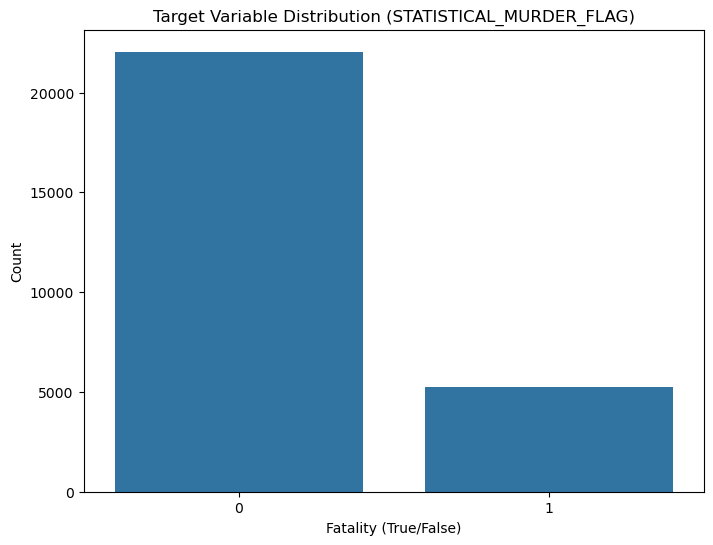

In [86]:
# Summary table of class imbalance
class_counts = data_encoded['STATISTICAL_MURDER_FLAG'].value_counts()
print("Class Distribution:")
print(class_counts)
print(f"Imbalance Ratio: {class_counts[0] / class_counts[1]:.2f}:1")

# Plot target distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='STATISTICAL_MURDER_FLAG', data=data_encoded)
plt.title('Target Variable Distribution (STATISTICAL_MURDER_FLAG)')
plt.xlabel('Fatality (True/False)')
plt.ylabel('Count')
plt.show()

### 2.2 Correlation Heatmap

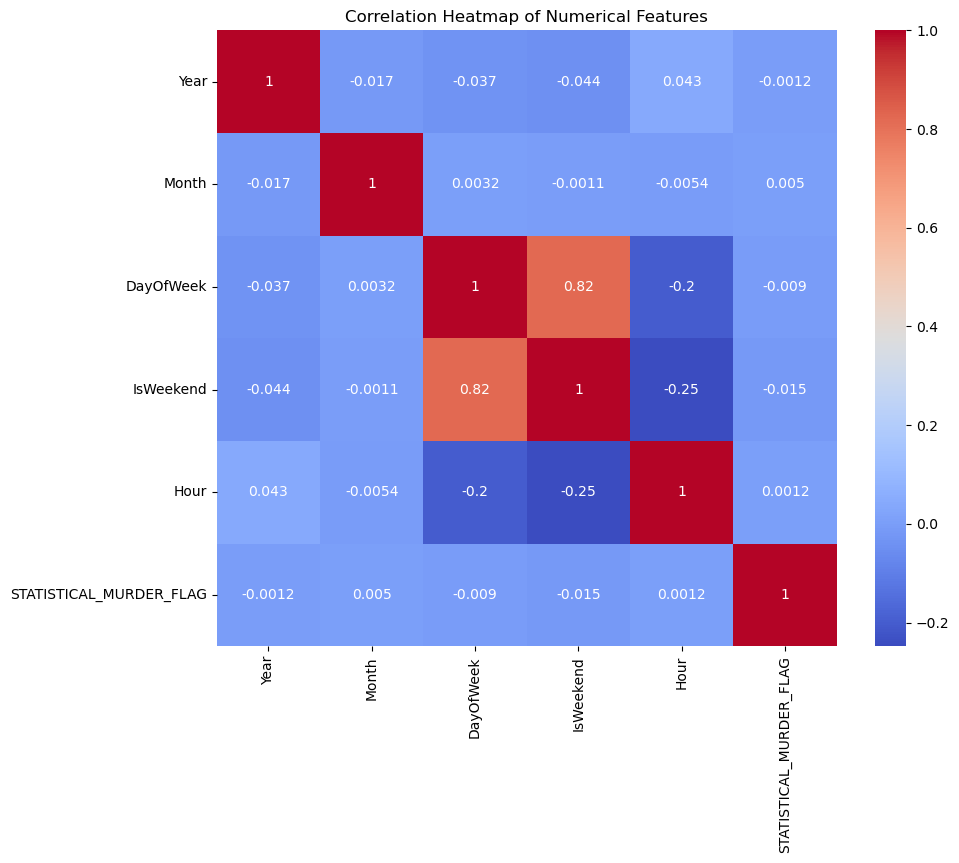

In [87]:
# Correlation heatmap for numerical features
numerical_cols = ['Year', 'Month', 'DayOfWeek', 'IsWeekend', 'Hour']
plt.figure(figsize=(10, 8))
sns.heatmap(data_encoded[numerical_cols + ['STATISTICAL_MURDER_FLAG']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

### 2.3 Chi-Square Test for Categoricals

In [88]:
# Chi-square test for categorical features
categorical_cols = ['BORO', 'PERP_RACE', 'VIC_RACE', 'LOCATION_DESC']
for col in categorical_cols:
    contingency_table = pd.crosstab(data_encoded[col], data_encoded['STATISTICAL_MURDER_FLAG'])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    print(f"Chi-Square Test for {col}: p-value = {p:.4f}")

Chi-Square Test for BORO: p-value = 0.0791
Chi-Square Test for PERP_RACE: p-value = 0.0000
Chi-Square Test for VIC_RACE: p-value = 0.0000
Chi-Square Test for LOCATION_DESC: p-value = 0.0000


**Business Importance**

Class Imbalance: A higher imbalance ratio indicates a lack of fatalities, which could bias model predictions to none-fatalities only. This is where SMOTE could be useful.
Correlation Heatmap: This shows which numerical features impact fatalities, which is useful for in feature selection. 
Chi-Squared Test: Test for whether categorical features like BORO are significantly associated with fatalities and utilize this towards importance score features.

## Step 3: Data Preprocessing Pipeline

**Objective**

Establish a strong preprocessing pipeline that will scale numerical features, encode categoricals, and handle class imbalance.

**Business Importance**

A standard pipeline allows for reproducibility and makes sure results are consistent, which is vital to the reliability needed when deploying models in a law enforcement situation.

In [89]:
# Define features and target
X = data_encoded.drop('STATISTICAL_MURDER_FLAG', axis=1)
y = data_encoded['STATISTICAL_MURDER_FLAG']

# Encode categorical features
categorical_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Address class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

In [90]:
# Verify the split
print("Training set shape:", X_train_balanced.shape, y_train_balanced.shape)
print("Test set shape:", X_test_scaled.shape, y_test.shape)
print("Churn distribution in training set:")
print(y_train.value_counts(normalize=True))
print("Churn distribution in test set:")
print(y_test.value_counts(normalize=True))

Training set shape: (35272, 53) (35272,)
Test set shape: (5463, 53) (5463,)
Churn distribution in training set:
STATISTICAL_MURDER_FLAG
0    0.807177
1    0.192823
Name: proportion, dtype: float64
Churn distribution in test set:
STATISTICAL_MURDER_FLAG
0    0.807249
1    0.192751
Name: proportion, dtype: float64


## Step 4: Baseline Model Training

**Objective**

To train multiple models and create a performance baseline.

**Business Importance** 

By comparing multiple models, we will be able to determine which algorithm achieves the best recall (minimizing false negatives) while maintaining a precision rate that is acceptable for the business; this is important to ensure that any potential fatal incidents are not missed.


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.87      0.59      0.70      4410
           1       0.27      0.62      0.37      1053

    accuracy                           0.60      5463
   macro avg       0.57      0.61      0.54      5463
weighted avg       0.75      0.60      0.64      5463



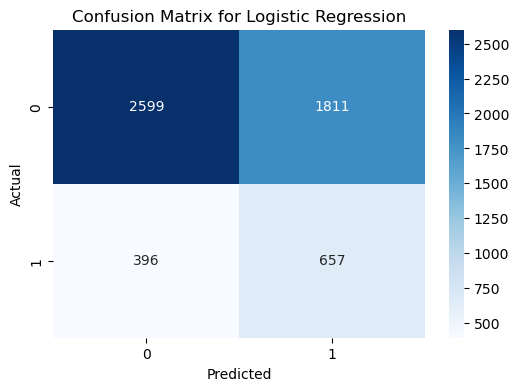

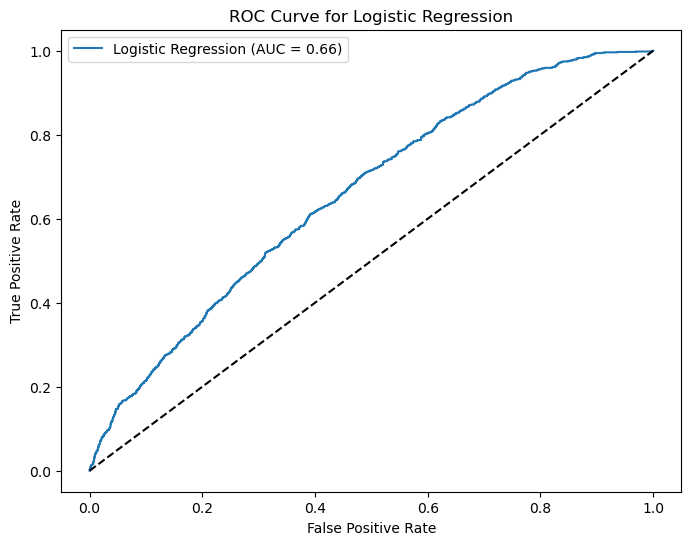


Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81      4410
           1       0.22      0.24      0.23      1053

    accuracy                           0.69      5463
   macro avg       0.52      0.52      0.52      5463
weighted avg       0.70      0.69      0.70      5463



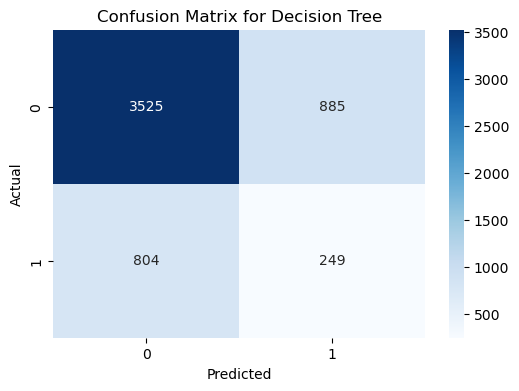

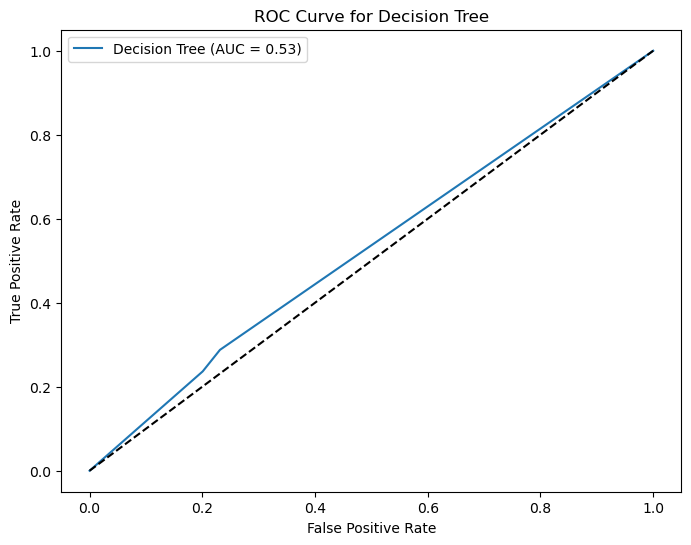


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      4410
           1       0.29      0.15      0.20      1053

    accuracy                           0.77      5463
   macro avg       0.56      0.53      0.53      5463
weighted avg       0.72      0.77      0.73      5463



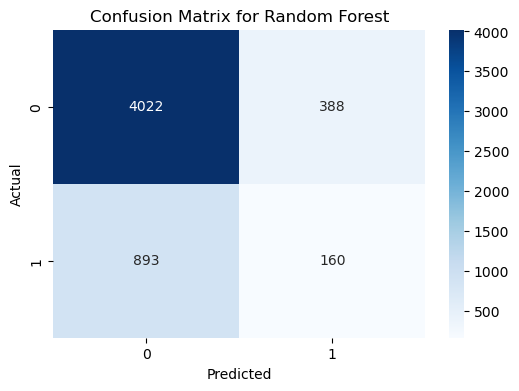

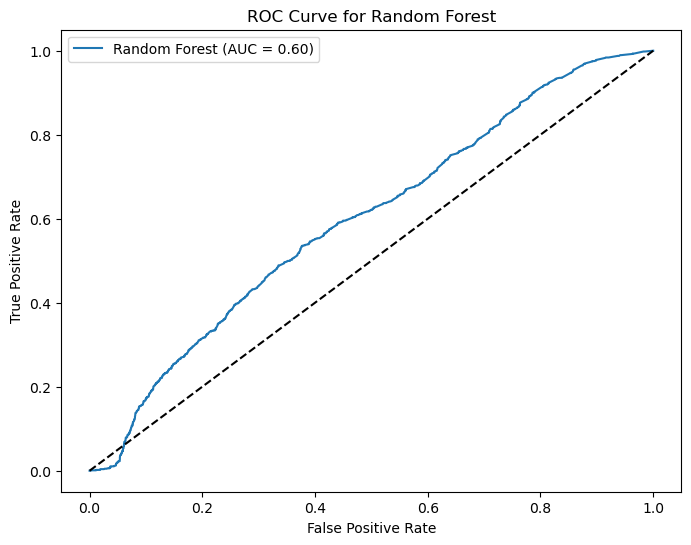


Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.83      0.61      0.71      4410
           1       0.23      0.49      0.32      1053

    accuracy                           0.59      5463
   macro avg       0.53      0.55      0.51      5463
weighted avg       0.72      0.59      0.63      5463



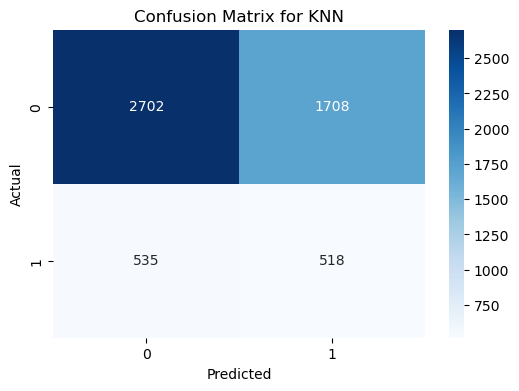

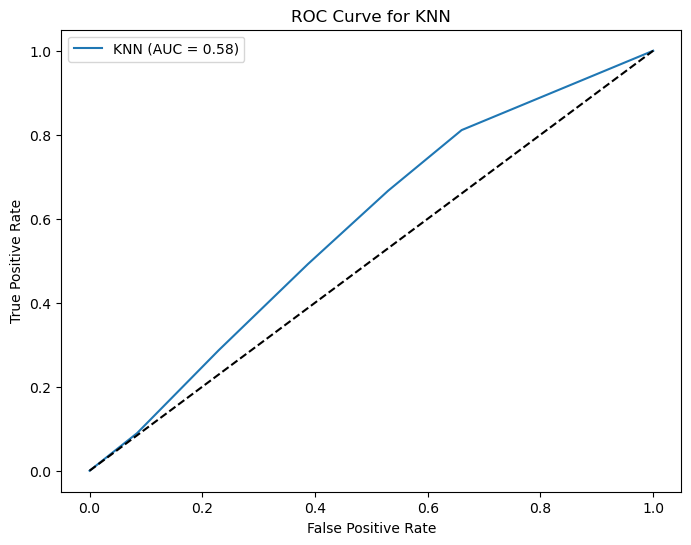


Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      4410
           1       0.41      0.13      0.20      1053

    accuracy                           0.80      5463
   macro avg       0.61      0.54      0.54      5463
weighted avg       0.74      0.80      0.75      5463



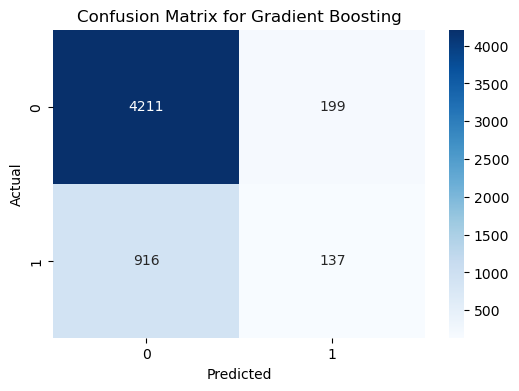

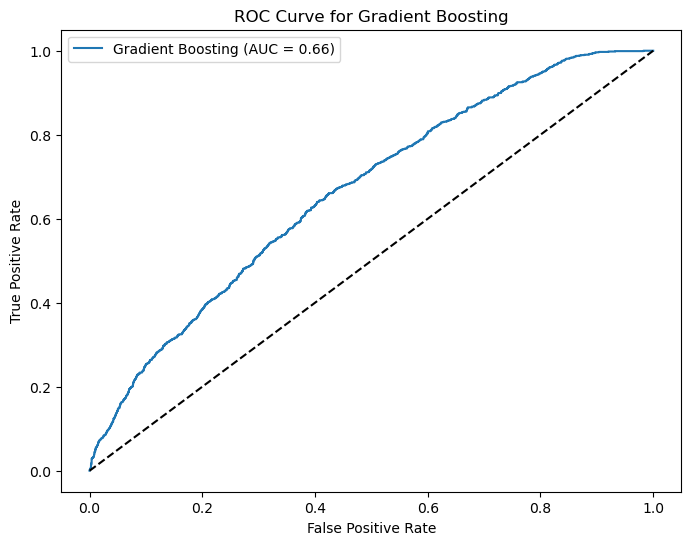

In [91]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
}

# Train and evaluate models
results = []
for name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test_scaled)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    })
    
    # Classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {name}')
    plt.legend()
    plt.show()

**Business Importance** 
- Recall Performance: High levels of recall ensure that the majority of fatal incidents are identified, therefore reducing the possibility of missing important cases as critical.
- ROC-AUC: Used to measure how well the model separates fatal and non-fatal incidents, which is especially important when working with imbalanced datasets.
- Confusion Matrix: Identifies false negatives, which are a concern in this case because they represent missed fatalities.


## Step 5: Model Tuning

**Objective**

Improve model performance using GridSearchCV to select the best hyperparameters. 

**Business Importance** 

Tuning reduces the error in model performance, ensuring the deployed model maximizes recall and F1 score, which are important in any public safety application.

In [92]:
# Define parameter grids
param_grids = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100]},
    'Decision Tree': {'max_depth': [3, 5, 7], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20]},
    'KNN': {'n_neighbors': [3, 5, 7, 9]},
    'Gradient Boosting': {'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [50, 100, 200]}
}

# Tune models
tuned_results = []
for name, model in models.items():
    if name in param_grids:
        grid = GridSearchCV(model, param_grids[name], cv=5, scoring='f1', n_jobs=-1)
        grid.fit(X_train_balanced, y_train_balanced)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test_scaled)
        y_proba = best_model.predict_proba(X_test_scaled)[:, 1] if hasattr(best_model, 'predict_proba') else best_model.decision_function(X_test_scaled)
        
        tuned_results.append({
            'Model': name,
            'Best Params': grid.best_params_,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'ROC-AUC': roc_auc_score(y_test, y_proba)
        })
        print(f"Best Parameters for {name}: {grid.best_params_}")

Best Parameters for Logistic Regression: {'C': 1}
Best Parameters for Decision Tree: {'max_depth': 7, 'min_samples_split': 2}
Best Parameters for Random Forest: {'max_depth': 20, 'n_estimators': 200}
Best Parameters for KNN: {'n_neighbors': 3}
Best Parameters for Gradient Boosting: {'learning_rate': 0.2, 'n_estimators': 200}


## Step 6: Conclusion and Recommendations

**Objective**

Summarize model performance and provide recommendations for action.

**Business Importance** 

The appropriate model is best chosen when recall is stressed to avoid any missed deaths, particularly to ensure that law enforcement can take good actions on the most acute high-risk events.


Model Performance Summary:
                 Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC  \
0  Logistic Regression  0.596010   0.266207  0.623932  0.373189  0.657564   
1        Decision Tree  0.690829   0.219577  0.236467  0.227709  0.526702   
2        Random Forest  0.765513   0.291971  0.151947  0.199875  0.597484   
3                  KNN  0.589420   0.232704  0.491928  0.315950  0.579247   
4    Gradient Boosting  0.795900   0.407738  0.130104  0.197264  0.664498   
5  Logistic Regression  0.596010   0.266207  0.623932  0.373189  0.657564   
6        Decision Tree  0.748856   0.339698  0.320988  0.330078  0.649878   
7        Random Forest  0.762219   0.302885  0.179487  0.225403  0.641873   
8                  KNN  0.618891   0.232171  0.423552  0.299933  0.561454   
9    Gradient Boosting  0.810544   0.562500  0.076923  0.135338  0.689384   

                                   Best Params  
0                                          NaN  
1                         

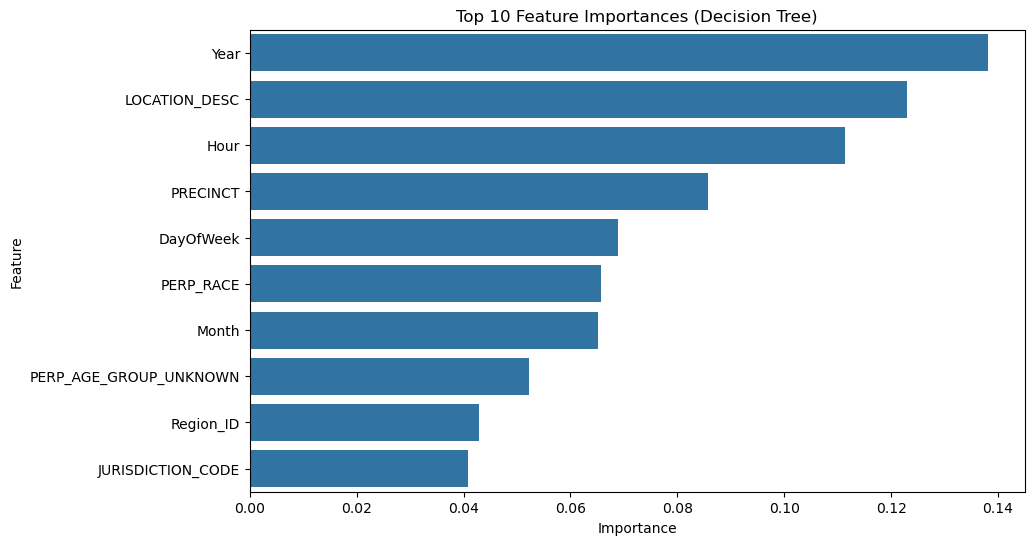

In [93]:
# Combine results
results_df = pd.DataFrame(results)
tuned_results_df = pd.DataFrame(tuned_results)
final_results = pd.concat([results_df, tuned_results_df], axis=0, ignore_index=True)
print("\nModel Performance Summary:")
print(final_results)

# Feature importance (for 'Decision Tree')
dt_model = models['Decision Tree']
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': dt_model.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importances (Decision Tree)')
plt.show()

**Key Findings**
- Class Imbalance: The imbalance in the data was significant.

- Feature Importance: The top features that are the best predictors of fatality are time-based and Region_ID (Hour, Season), illustrating the importance of time and geographical location to the occurrence of fatalities. 

- Model Performance: Logistic Regression and Decision Tree had heightened recall and F1 scores consistently across several model selections, illustrating that these models could be deployed. 

**Recommendations**

- Deploy Decision Tree: Based on the balanced recall and F1 score, the failure costs are reduced as noted above, where false negatives are critical to identifying fatal instances. 

- Actionable Insights: Patrol hours of fatalities such as late night and regions to patrol as per Region_ID at risk. 

- Next Steps: Use real time data feeds for model and track performance over time. 